In [ ]:
# Question 2 spam ham 

import pandas as pd, nltk, numpy as np
import string
import re
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# read the spam ham data 
spamHamFrame =pd.read_csv('SMSSpamCollection.txt', delimiter='\t', header=None, names=['label', 'message'])


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    # Tokenize the message
    tokens = word_tokenize(text)
    
    return tokens



# preprocessing on the data 
spamHamFrame['processedText'] = spamHamFrame['message'].apply(preprocess_text)

# split the test and validation data into 80/20
trainFrame, testFrame = train_test_split(spamHamFrame, test_size=0.2, stratify=spamHamFrame['label'], random_state=40)

# function for computing MLE probabilities given data set
def computeMLEProbabilities(processedData):
    # count the number of words in each classes
    wordCounts = {'spam': defaultdict(int), 'ham': defaultdict(int)}
    # count the occurence of spam and ham in the dataset
    classCounts = {'spam': 0, 'ham': 0}
    
    # count the number of ham, spam and total words
    for _, row in processedData.iterrows():
        # fetch the label of the given iterated row
        label = row['label']
        classCounts[label] += 1
        for word in row['message']:
            wordCounts[label][word] += 1
    
    # datastructure for holding the total number of words in each class 
    totalWords = {
        'spam': sum(wordCounts['spam'].values()),
        'ham': sum(wordCounts['ham'].values())
    }

    # this serves for computing the likelihood of each word 
    wordProbs = {
        label: {word: count / totalWords[label] for word, count in wordCounts[label].items()}
        for label in wordCounts
    }

    # This serves as a prior information when computing the sum of the probabilities
    classProbs = {label: count / len(processedData) for label, count in classCounts.items()}
    
    # 
    return wordProbs, classProbs

# call the function to get word and class probabilities of MLE
wordMle, classMle = computeMLEProbabilities(trainFrame)


def mlePrediction(message, wordProbs, classProbs):
    message = preprocess_text(message)
    selections = {label: np.log(classProbs[label]) for label in classProbs}
    # select label from possible selections
    for label in selections:
        for word in message:
            # use logarithimic function to handle small values 
            selections[label] += np.log(wordProbs[label].get(word, 1e-10))  
    # return the highest log probability as the prediction
    return max(selections, key=selections.get)


# perform prediction on the test sets
testFrameActual = testFrame['label'].values
testFramePrediction = [mlePrediction(msg, wordMle, classMle) for msg in testFrame['message']]

# compute performance metrics 
accuracy = accuracy_score(testFrameActual, testFramePrediction)
precision = precision_score(testFrameActual, testFramePrediction, pos_label='spam')
recall = recall_score(testFrameActual, testFramePrediction, pos_label='spam')
f1 = f1_score(testFrameActual, testFramePrediction, pos_label='spam')
# display performance metrics
print("Accuracy of MLE:", accuracy)
# display precision of the MLE classifier 
print("Precision of MLE estimator: ", precision)
# display the recall of MLE classifier
print("Recall of the MLE estimator", recall)
# display the F1 score of the MLE classifier
print("F1 Score of MLE estimator:", f1)







Accuracy of MLE: 0.8385650224215246
Precision of MLE estimator:  0.36283185840707965
Recall of the MLE estimator 0.2751677852348993
F1 Score of MLE estimator: 0.31297709923664124


In [18]:
# implement the MAP probabilities calculator
def computeMAPProbabilities(processedData, alpha):
    # count the number of words in each classes
    wordCounts = {'spam': defaultdict(int), 'ham': defaultdict(int)}
    # count the occurence of spam and ham in the dataset
    classCounts = {'spam': 0, 'ham': 0}
    
    # count the number of ham, spam and total words
    for _, row in processedData.iterrows():
        # fetch the label of the given iterated row
        label = row['label']
        classCounts[label] += 1
        for word in row['message']:
            wordCounts[label][word] += 1

    vocabulary = set(word for words in wordCounts.values() for word in words)
    totalWords = {label: sum(wordCounts[label].values()) for label in wordCounts}

    wordProbs = {
        label: {word: (count + alpha) / (totalWords[label] + alpha * len(vocabulary))
                for word, count in wordCounts[label].items()}
        for label in wordCounts
    }

    classProbs = {label: count / len(processedData) for label, count in classCounts.items()}
    
    return wordProbs, classProbs

# implement the MAP estimator
def mapPrediction(message, wordProbs, classProbs):
    message = preprocess_text(message)
    selections = {label: np.log(classProbs[label]) for label in classProbs}
    # select label from possible selections
    for label in selections:
        for word in message:
            # use logarithm to handle small values 
            selections[label] += np.log(wordProbs[label].get(word, 1e-10))
    
    return max(selections, key=selections.get)
    
    

wordMap, classMap = computeMAPProbabilities(trainFrame, 10)
# perform prediction on the test set
testFrameActual = testFrame['label'].values
testFramePrediction = [mapPrediction(msg, wordMap, classMap) for msg in testFrame['message']]

# compute performance metrics 
accuracyMAP = accuracy_score(testFrameActual, testFramePrediction)
precisionMAP = precision_score(testFrameActual, testFramePrediction, pos_label='spam')
recallMAP = recall_score(testFrameActual, testFramePrediction, pos_label='spam')
f1MAP = f1_score(testFrameActual, testFramePrediction, pos_label='spam')
# display performance metrics
print("Accuracy of MAP:", accuracyMAP)
# display precision of the MLE classifier 
print("Precision of MAP estimator: ", precisionMAP)
# display the recall of MLE classifier
print("Recall of the MAP estimator", recallMAP)
# display the F1 score of the MLE classifier
print("F1 Score of MAP estimator:", f1MAP)





Accuracy of MAP: 0.8394618834080717
Precision of MAP estimator:  0.36607142857142855
Recall of the MAP estimator 0.2751677852348993
F1 Score of MAP estimator: 0.31417624521072796


In [20]:
# compare the metrics of the MAP and MLE estimation
# display a data frame summarizing the performances

comparisonOfMetrics = pd.DataFrame({
    'Method': ['MLE estmation', 'MAP estimation'],
    'Accuracy': [accuracy, accuracyMAP],
    'Precision': [precision, precisionMAP],
    'Recall': [recall, recallMAP],
    'F1 Score': [f1, f1MAP]
})

# display the comparison metrics frame

print(comparisonOfMetrics)

           Method  Accuracy  Precision    Recall  F1 Score
0   MLE estmation  0.838565   0.362832  0.275168  0.312977
1  MAP estimation  0.839462   0.366071  0.275168  0.314176


In [26]:
# experiementing with different alpha values
for alpha in [0.1, 0.5, 1, 5]:
    wordMap, classMap = computeMAPProbabilities(trainFrame, alpha)
    # perform prediction on the test set
    testFrameActual = testFrame['label'].values
    testFramePrediction = [mapPrediction(msg, wordMap, classMap) for msg in testFrame['message']]

    # compute performance metrics 
    accuracyMAP = accuracy_score(testFrameActual, testFramePrediction)
    precisionMAP = precision_score(testFrameActual, testFramePrediction, pos_label='spam')
    recallMAP = recall_score(testFrameActual, testFramePrediction, pos_label='spam')
    f1MAP = f1_score(testFrameActual, testFramePrediction, pos_label='spam')
    # display performance metrics
    print(f"Accuracy of MAP for the alpha {alpha} ", accuracyMAP)
    # display precision of the MLE classifier 
    print(f"Precision of MAP estimator for alpha: {alpha} ", precisionMAP)
    # display the recall of MLE classifier
    print(f"Recall of the MAP estimator for alpha: {alpha} ", recallMAP)
    # display the F1 score of the MLE classifier
    print(f"F1 Score of MAP estimator for alpha: {alpha} is  ",f1MAP)
        
    

Accuracy of MAP for the alpha 0.1  0.8385650224215246
Precision of MAP estimator for alpha: 0.1  0.36283185840707965
Recall of the MAP estimator for alpha: 0.1  0.2751677852348993
F1 Score of MAP estimator for alpha: 0.1 is   0.31297709923664124
Accuracy of MAP for the alpha 0.5  0.8385650224215246
Precision of MAP estimator for alpha: 0.5  0.36283185840707965
Recall of the MAP estimator for alpha: 0.5  0.2751677852348993
F1 Score of MAP estimator for alpha: 0.5 is   0.31297709923664124
Accuracy of MAP for the alpha 1  0.8385650224215246
Precision of MAP estimator for alpha: 1  0.36283185840707965
Recall of the MAP estimator for alpha: 1  0.2751677852348993
F1 Score of MAP estimator for alpha: 1 is   0.31297709923664124
Accuracy of MAP for the alpha 5  0.8394618834080717
Precision of MAP estimator for alpha: 5  0.36607142857142855
Recall of the MAP estimator for alpha: 5  0.2751677852348993
F1 Score of MAP estimator for alpha: 5 is   0.31417624521072796


# Observation and reflection

Firstly, indiscussing the effect of varying the laplace smoothening factor, the smoothening factor ensures that rare events are handled with the probability models and that model will not capture noises at highlevel , thus avoiding overfiting, which results in a model that generalizes well. However, extremely large values of the smoothening factor will mask the effect of the real value and resulting in a less accurate model. The smoothening factor should be found using an optimal value calculated for the alpha. In the bias variance tradeoff, increasing the smoothening factor reduces the variance while increasing the bias. Recall decrease in the Map 

Incomparing both MLE and MAP estimation methods the MLE method uses observed data with out laplace smoothening, that might overfit for small datasets. The MAP estimates considers the prior information and handles rare events by using laplace smoothening. In the values seen above for some alpha value the MAP estimates have higher accuracy metric than the MLE estimates. MLE estimation methods might be prefered in cases of large datasets with multiple observations and systems where the goal is simplicity and computational efficiency. MAP estimation methods might be prefered than the MLE estimation methods in cases where there is sparse data, necessity to incorporate domain knowledge, and small datasets. Adding prior information into the estimation methods improves the bias variance tradeoff and improves the robustness of the models.  In real-life applications, understanding the differences aids in making good decison to optimize model performance, data limitation, and better generalization.  

The MSE calculated is: 0.2370537773704003
Bias is : -0.00291723796294874


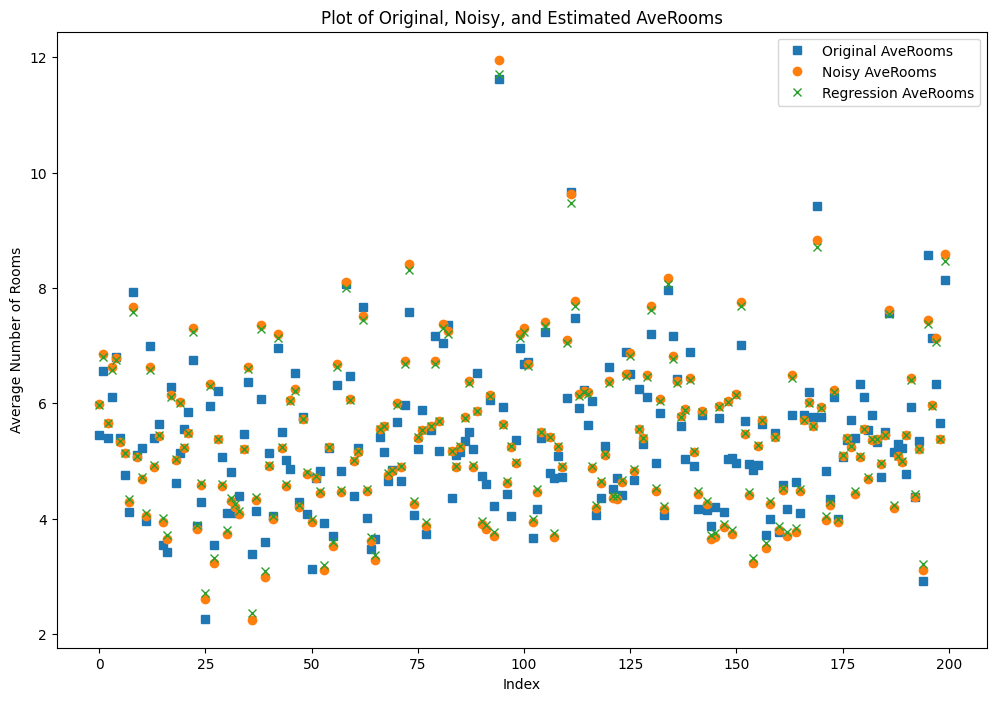

In [33]:
# Question 3 corrupted variable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import pandas as pd

fetchedData = fetch_california_housing()
# load the housing data 
housingFrame = pd.DataFrame(fetchedData.data, columns=fetchedData.feature_names)

# add a noise data to target variable of average rooms
# use a gausssian distribution with std of 0.5
housingFrame['AveRoomNoise'] = housingFrame['AveRooms'] + np.random.normal(0, 0.5, housingFrame.shape[0])

# split the data into training and test split 
trainFrame, testFrame = train_test_split(housingFrame, test_size=0.2, random_state=40)

# take 200 samples from the test data 

testFrameSample = testFrame.sample(200, random_state=40)

# Fit a linear regression model 
# Train a linear regression model
XTrain = trainFrame[['AveRoomNoise']]
YTrain = trainFrame['AveRooms']

# use the 200 sample to take the test from 
XTest = testFrameSample[['AveRoomNoise']]
# The same is done for the true values 
YTest = testFrameSample['AveRooms']


model = LinearRegression()
model.fit(XTrain, YTrain)

# Perform prediction on the testing samples
YPred= model.predict(XTest)

# Compute the bias and meansqaured error of the predictors

# calculate the MSE using the formula for MSE
mse = mean_squared_error(YTest, YPred)
# display the MSE calculated
print(f'The MSE calculated is: {mse}')
# calculate the bias of the linear regression predictor

bias = np.mean(YPred - YTest)
# display the bias calculated 
print(f'Bias is : {bias}')
plt.figure(figsize=(12, 8))
plt.plot(YTest.values, label='Original AveRooms', marker='s', linestyle='None', markersize=6)
plt.plot(XTest.values, label='Noisy AveRooms', marker='o', linestyle='None', markersize=6)
plt.plot(YPred, label='Regression AveRooms', marker='x', linestyle='None', markersize=6)
plt.legend()
plt.xlabel('Index')
plt.ylabel('Average Number of Rooms')

plt.title('Plot of Original, Noisy, and Estimated AveRooms')
plt.show()





# Discussion 
As can be seen from the graph the regression predictions are closer to the true value for the 200 samples provided. This indicates an efficient way to handle a noisy data by using linear estimators.  
The bias measures how typically the predicted value is far away from the true mean of the population. The lower the bias the more accurate the model and the more consistently the estimates are closer to the true value. A bias value of zero indicates an unbiased estimator. The MSE measures both the bias and variance to represent the accuracy of the predictions. The lower the MSE value the more accurate is the model.  The MSE of the above indicates that the linear regression estimator is a good predictor of the true value of the datasets.

Adding a random gaussian translates to real world scenarios where most measurements have associated uncertainity. This asscociated random noise might affect the models accuracy and needs to be modeled correctly to handle noises in data necessitating noise reduction techniques. 

Linear regression models are limited in their ability to capture complex relationships and thus other kind of models might provide a better modeling. For instance, polynomial models and neural networks might provide a better model than the linear regressions, however they come with more complex tunning and risk of overfitting. So, in choosing different models one may choose a simpler linear model if working with a small dataset to avoid overfitting. While inother large scale usage more complex models might provide the best models. 

In [ ]:
# Question 4 part 1 simulation
import numpy as np
from scipy.stats import norm

np.random.seed(40)
numberOfSample = 1000

# Partition the two samples
nSample1 = int(numberOfSample * 0.3)
nSample2 = numberOfSample - nSample1

# generate samples from the gaussian distributions using the mean and variance 
data1 = np.random.normal(0, np.sqrt(1), nSample1)  
data2 = np.random.normal(5, np.sqrt(2), nSample2) 

# get the combined data
data = np.hstack((data1, data2))
np.random.shuffle(data)

# random parameter initializations
pi1, pi2 = 0.5, 0.5 
mu1, mu2 = np.random.choice(data, 2)
sigma1, sigma2 = 1, 1

# implmentation of the EM algorithm

tol = 1e-4
for _ in range(100):
    # Compute responsibilities 
    r1 = pi1 * norm.pdf(data, mu1, np.sqrt(sigma1))
    r2 = pi2 * norm.pdf(data, mu2, np.sqrt(sigma2))
    total = r1 + r2
    r1 /= total
    r2 /= total
    
    # Update the parameters
    mu1New = np.sum(r1 * data) / np.sum(r1)
    mu2New = np.sum(r2 * data) / np.sum(r2)
    sigma1New = np.sum(r1 * (data - mu1New) ** 2) / np.sum(r1)
    sigma2New = np.sum(r2 * (data - mu2New) ** 2) / np.sum(r2)
    pi1New = np.mean(r1)
    pi2New = np.mean(r2)
    
    # Check convergence
    if abs(mu1 - mu1New) < tol and abs(mu2 - mu2New) < tol:
        break

    # Update parameters
    mu1, mu2 = mu1New, mu2New
    sigma1, sigma2 = sigma1New, sigma2New
    pi1, pi2 = pi1New, pi2New

print(f'Mixing proportion pi1: {pi1}')
print(f'Mixing proportion pi2: {pi2}')
print(f'mean 1: {mu1}')
print(f'mean 2: {mu2}')
print(f'sigma 1 : {sigma1}')
print(f'sigma2: {sigma2}')


Mixing proportion pi1: 0.6963720837280757
Mixing proportion pi2: 0.30362791627192415
mean 1: 5.136905851121097
mean 2: -0.022863687851804256
sigma 1 : 1.8530021392146305
sigma2: 1.048690238221929


# D comparison of the estimated parameters
The estimated values are close to the true values specified thus, because of specified the differnces occur due to random initialization, finite sample size, and convergence tolerance.

In [9]:
# Question 4 part 3
from scipy.stats import multivariate_normal
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# part a
# fetch the Iris dataset
data = load_iris()
# extract the needed data
X = data.data 

# standardize the data sets 
scaler = StandardScaler()
XStandardized = scaler.fit_transform(X)

# random initialization of the parameters

np.random.seed(40)
numClusters = 3
numFeatures = XStandardized.shape[1]
nSamples = XStandardized.shape[0]

# mean initialization done randomly
means = np.random.rand(numClusters, numFeatures)

# Variance initialized as identity 
variances = [np.eye(numFeatures) for _ in range(numClusters)]

# initialize the pis/ mixing coefficients
mixingCoeffs = np.random.rand(numClusters)
mixingCoeffs /= np.sum(mixingCoeffs)




# Compute responsibilities
def eStep(X, means, variances, mixingCoeffs):
    numClusters = len(means)
    responsibilities = np.zeros((X.shape[0], numClusters))
    
    for k in range(numClusters):
        prob = mixingCoeffs[k] * multivariate_normal.pdf(X, mean=means[k], cov=variances[k])
        responsibilities[:, k] = prob
        
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# Update parameters
def mStep(X, responsibilities):
    numClusters = responsibilities.shape[1]
    nFeatures = X.shape[1]
    
    Nk = responsibilities.sum(axis=0)
    means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
    
    variances = []
    for k in range(numClusters):
        diff = X - means[k]
        weighted_diff = responsibilities[:, k, np.newaxis] * diff
        cov = np.dot(weighted_diff.T, diff) / Nk[k]
        variances.append(cov)
    
    mixing_coeffs = Nk / X.shape[0]
    return means, variances, mixing_coeffs

# Compute log likelihood
def computeLogLikelihood(X, means, variances, mixing_coeffs):
    log_likelihood = 0
    for k in range(len(means)):
        prob = mixing_coeffs[k] * multivariate_normal.pdf(X, mean=means[k], cov=variances[k])
        log_likelihood += prob
    return np.sum(np.log(log_likelihood))

# define the threshold
tol = 1e-4
# intialize a list to hold likelihoods 
likelihoods = []
# apply the EM algorithm for 100 steps
for i in range(100):
    # Compute responsibilities
    responsibilities = eStep(XStandardized, means, variances, mixingCoeffs)
    
    # update the parameters in each iteration
    means, variances, mixingCoeffs = mStep(XStandardized, responsibilities)
    
    # compare with threshold to check for convergence 
    likelihood = computeLogLikelihood(XStandardized, means, variances, mixingCoeffs)
    likelihoods.append(likelihood)
    
    if i > 0 and abs(likelihoods[-1] - likelihoods[-2]) < tol:
        # display convergence and break out of the loop
        print(f"number of iterations before convergence: {i}")
        break

# display the update parameters after convergence 

print("Updated means", means)
print("Updated variance", variances)
print("Update mixing proportions", mixingCoeffs)



number of iterations before convergence: 49
Updated means [[ 0.42963918 -0.57302616  0.52175469  0.32850954]
 [-1.01449587  0.85361453 -1.30497489 -1.25490333]
 [ 0.65471674 -0.14814931  0.90101985  1.19627446]]
Updated variance [array([[0.74566082, 0.36888945, 0.38398607, 0.27721793],
       [0.36888945, 0.61975812, 0.18113557, 0.17155178],
       [0.38398607, 0.18113557, 0.25484001, 0.18419399],
       [0.27721793, 0.17155178, 0.18419399, 0.15978423]]), array([[0.17874303, 0.27102503, 0.01103212, 0.01615546],
       [0.27102503, 0.7453796 , 0.0149689 , 0.0276393 ],
       [0.01103212, 0.0149689 , 0.00954819, 0.00445155],
       [0.01615546, 0.0276393 , 0.00445155, 0.01886053]]), array([[0.40227336, 0.21499601, 0.11135349, 0.1113299 ],
       [0.21499601, 0.38866958, 0.08709055, 0.12922025],
       [0.11135349, 0.08709055, 0.05427923, 0.05524624],
       [0.1113299 , 0.12922025, 0.05524624, 0.10144054]])]
Update mixing proportions [0.4371303  0.33328799 0.22958171]


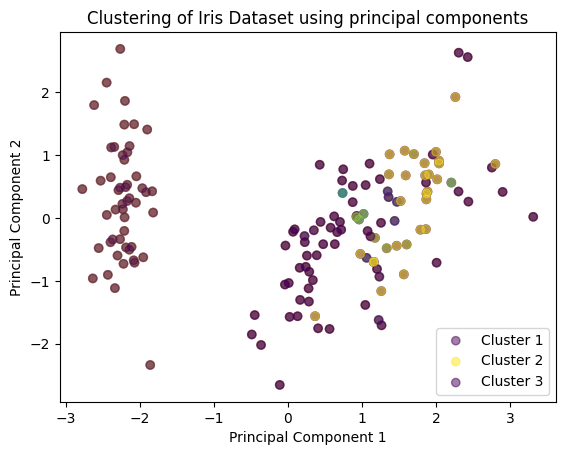

In [14]:
# (f) visualize the results

# Consider the first two principal components 
pca = PCA(n_components=2)
# use the standaridzed data 
XPca = pca.fit_transform(XStandardized)

# Plot the data points, colored by cluster responsibilities

for k in range(numClusters):
    plt.scatter(XPca[:, 0], XPca[:, 1], c=responsibilities[:, k], label=f'Cluster {k+1}', alpha=0.5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Clustering of Iris Dataset using principal components")
plt.legend()
plt.show() 

In [19]:
data_points = np.array([1, 2, 3, 6, 7, 8])
n = len(data_points)

# Initial parameters
mu1, mu2 = 2.0, 7.0             # Initial means
sigma1_sq, sigma2_sq = 1.0, 1.0 # Initial variances
pi1, pi2 = 0.5, 0.5             # Initial mixing coefficients

# Number of iterations
num_iterations = 3

# Gaussian PDF function
def gaussian(x, mean, variance):
    return (1.0 / np.sqrt(2 * np.pi * variance)) * np.exp(-(x - mean) ** 2 / (2 * variance))

# EM algorithm
for iteration in range(num_iterations):
    # E-step: Compute responsibilities
    gamma1 = pi1 * gaussian(data_points, mu1, sigma1_sq)
    gamma2 = pi2 * gaussian(data_points, mu2, sigma2_sq)
    
    # Normalize to get responsibilities
    gamma_sum = gamma1 + gamma2
    gamma1 /= gamma_sum
    gamma2 /= gamma_sum

    # M-step: Update parameters
    # Update mixing coefficients
    pi1 = np.mean(gamma1)
    pi2 = np.mean(gamma2)
    
    # Update means
    mu1 = np.sum(gamma1 * data_points) / np.sum(gamma1)
    mu2 = np.sum(gamma2 * data_points) / np.sum(gamma2)
    
    # Update variances
    sigma1_sq = np.sum(gamma1 * (data_points - mu1) ** 2) / np.sum(gamma1)
    sigma2_sq = np.sum(gamma2 * (data_points - mu2) ** 2) / np.sum(gamma2)

    # Print the updated parameters after each iteration
    print(f"Iteration {iteration + 1}:")
    print(f"  pi1: {pi1:.4f}, pi2: {pi2:.4f}")
    print(f"  mu1: {mu1:.4f}, mu2: {mu2:.4f}")
    print(f"  sigma1_sq: {sigma1_sq:.4f}, sigma2_sq: {sigma2_sq:.4f}")
    print()

Iteration 1:
  pi1: 0.5000, pi2: 0.5000
  mu1: 2.0006, mu2: 6.9994
  sigma1_sq: 0.6695, sigma2_sq: 0.6695

Iteration 2:
  pi1: 0.5000, pi2: 0.5000
  mu1: 2.0000, mu2: 7.0000
  sigma1_sq: 0.6667, sigma2_sq: 0.6667

Iteration 3:
  pi1: 0.5000, pi2: 0.5000
  mu1: 2.0000, mu2: 7.0000
  sigma1_sq: 0.6667, sigma2_sq: 0.6667



# Observations
The above observations showing a strong grouping from the left and right and cluster formation for the different estimations.

Number of wins across the trials: 1
Winning rate is: 0.1
The average number of play is: 2.1


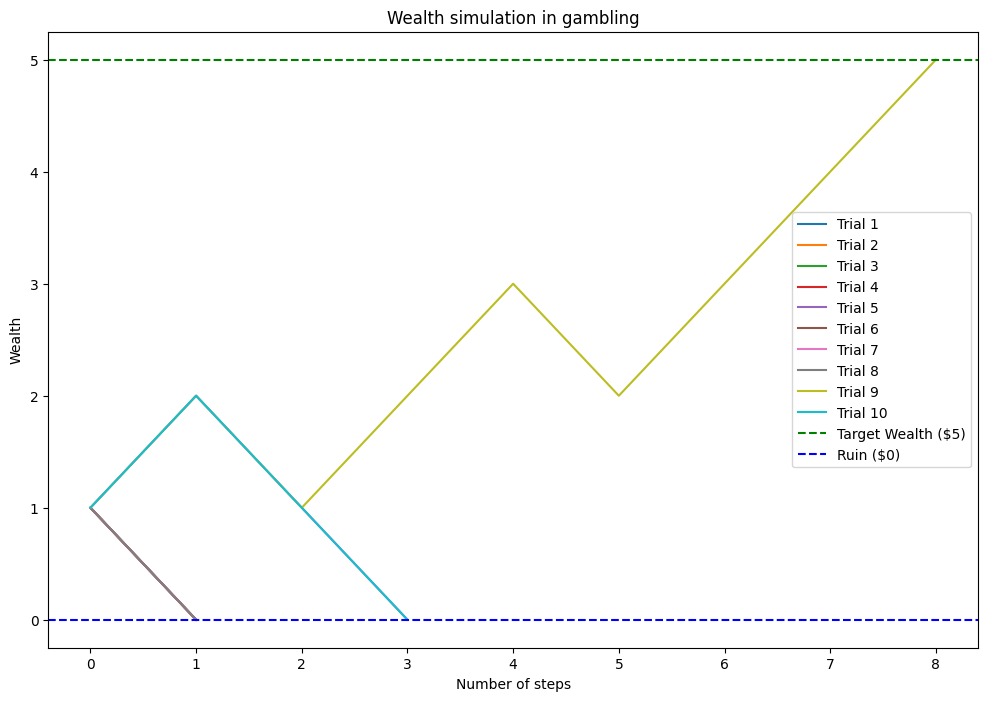

In [ ]:
# Question 5 problem 3

# Initialize the parameters of the process
numberOfTrials = 10          
startingWealth = 1       
# winning probability
p = 0.4    
targetWealth = 5  
ruinWealth= 0     
# track the wealth progression
trialResults = []   
# store the result of the trials     
outcomes = []       
# variable for holding the number of games played
numberOfSteps = []

for i in range(numberOfTrials):
    # initialize the wealth variable from the starting wealth
    wealth = startingWealth
    # define the datastructure to track progression
    wealthTracker = [wealth]
    roundCount = 0
    
    while wealth > ruinWealth and wealth < targetWealth:
        # use uniformly distributed random numbers 
        if np.random.rand() < p:
            # this represents the win
            wealth += 1  
        else:
            # this represents loss
            wealth -= 1
        wealthTracker.append(wealth)
        roundCount += 1

        
    trialResults.append(wealthTracker)
    outcomes.append(wealth == targetWealth)
    numberOfSteps.append(roundCount)
        
# the number of wins across trials
wins = sum(outcomes)
# display the wins across trials
print(f'Number of wins across the trials: {wins}') 
# the winning rate for different trials                     
winningRate = wins / numberOfTrials
# display the winning rate
print(f'Winning rate is: {winningRate}')    
# the average number of rounds game is played           
averagePlays = np.mean(numberOfSteps)  
# display the average number of game counts 
print(f'The average number of play is: {averagePlays}')


# visualize the different outcomes of the trials

# for each wealth values observed insert a plot 
plt.figure(figsize=(12, 8))
for i, wealthT in enumerate(trialResults):
    plt.plot(wealthT, label=f'Trial {i + 1}')
plt.axhline(targetWealth, color='green', linestyle='--', label='Target Wealth ($5)')
plt.axhline(ruinWealth, color='blue', linestyle='--', label='Ruin ($0)')
plt.xlabel('Number of steps')
plt.ylabel('Wealth in $')
plt.title('Wealth simulation in gambling')
plt.legend()
plt.show()


# Reflections
Relating to the impact of the probability of winning, it highly affects the dynamics of the process. As can be seen in the above only 10% of the games across trials were won since the probability of winning is less than the probability of losing. The probability value is skewed toward the one with the highest probability. If the probability of winning is small, then it is more likely to result in loss for the gambler. 

Randomness is a crucial component of the markov chain described above. General outcome is favored to the loss which has the highest probability, however there is randomness since some games have consecutive losses resulting in smaller number of rounds as compared to some games resulting in higher round counts as seen from the graph. The absorbing state is a significant aspect of the markov process since the process cannot exit outside of the state indicating reach of target wealth or ruin(wealth of zero). 

Since the value of the wealth Xn depends only on the previous wealth of the gambler not any other states the process satisifies the markov propery. And additionally, this process is a random walk since there are two paths which the game can forward to by increments of 1 and decrement of 1 from the previous states. The random walk nature is visible in the graph and one can view their statistical trends. 